In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
#from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

2024-08-15 09:49:31.034454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 09:49:31.034517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 09:49:31.036053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import pandas as pd

healthy_dirs = [
'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
'/kaggle/input/osteoporosis/osteoporosis/normal',
'/kaggle/input/osteoporosis-knee-xray-dataset/normal'
]

osteoporosis_dirs = [
'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
'/kaggle/input/osteoporosis/osteoporosis/osteoporosis',
'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         595
Name: count, dtype: int64


In [4]:
knee_osteoporosis_df.shape

(1388, 2)

In [5]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1110, 2)
(417, 2)
(278, 2)
(971, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1109 validated image filenames belonging to 2 classes.
Found 416 validated image filenames belonging to 2 classes.
Found 278 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

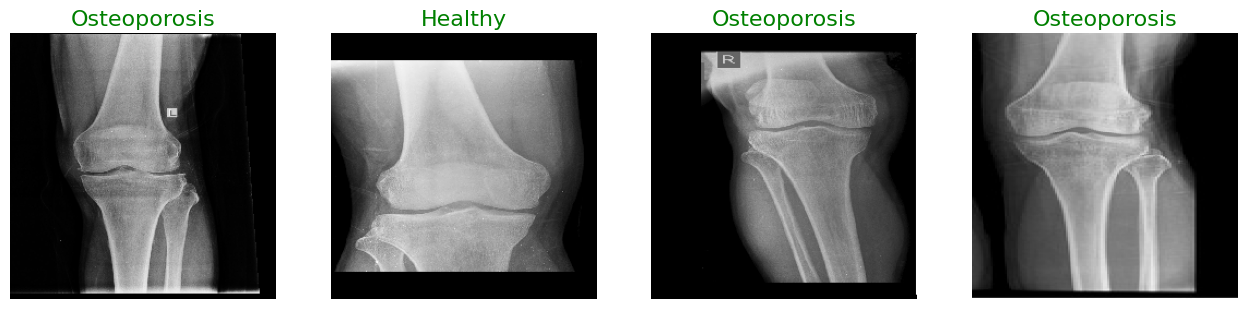

In [10]:
show_knee_images(train)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, InputLayer

# Define the modified model
alexnet_model = Sequential([
    # Input Layer
    InputLayer(shape=(244, 244, 3)),

    # Conv Layer 1
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 2
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 3
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer
    Flatten(),

    # Dense Layers
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Adjust the number of units based on your number of classes
])


In [12]:
# Compile the mo del
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
batch_size = 16  
history_alexnet1 = alexnet_model.fit(train, epochs=5, validation_data=val, verbose=1,batch_size=batch_size)

Epoch 1/5
  1/278 ━━━━━━━━━━━━━━━━━━━━ 1:57:00 25s/step - accuracy: 0.2500 - loss: 1.7798

I0000 00:00:1723715402.994524     346 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723715403.020626     346 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5648 - loss: 116.6389

W0000 00:00:1723715436.975883     349 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


278/278 ━━━━━━━━━━━━━━━━━━━━ 66s 147ms/step - accuracy: 0.5649 - loss: 116.6693 - val_accuracy: 0.6115 - val_loss: 22.4308
Epoch 2/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.6157 - loss: 51.0956 - val_accuracy: 0.7662 - val_loss: 34.4896
Epoch 3/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.6430 - loss: 22.3638 - val_accuracy: 0.7230 - val_loss: 13.0481
Epoch 4/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6829 - loss: 11.9743 - val_accuracy: 0.6511 - val_loss: 6.4416
Epoch 5/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.7364 - loss: 5.0338 - val_accuracy: 0.7770 - val_loss: 2.1129


In [14]:
alexnet_model.evaluate(test, verbose=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7774 - loss: 2.1699


[1.9586243629455566, 0.776442289352417]

In [15]:
batch_size = 16  
history_alexnet2 = alexnet_model.fit(train, epochs=1, validation_data=val, verbose=1,batch_size=batch_size)

278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6983 - loss: 4.0903 - val_accuracy: 0.7878 - val_loss: 1.5007


In [16]:
alexnet_model.evaluate(test, verbose=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7804 - loss: 1.4825


[1.3659019470214844, 0.7788461446762085]

In [17]:
alexnet_model.save("Osteoporosis_Model_binary.h5")

  6/104 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

W0000 00:00:1723716209.963274     346 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.74      0.74      0.74       178
Osteoporosis       0.81      0.81      0.81       238

    accuracy                           0.78       416
   macro avg       0.77      0.77      0.77       416
weighted avg       0.78      0.78      0.78       416



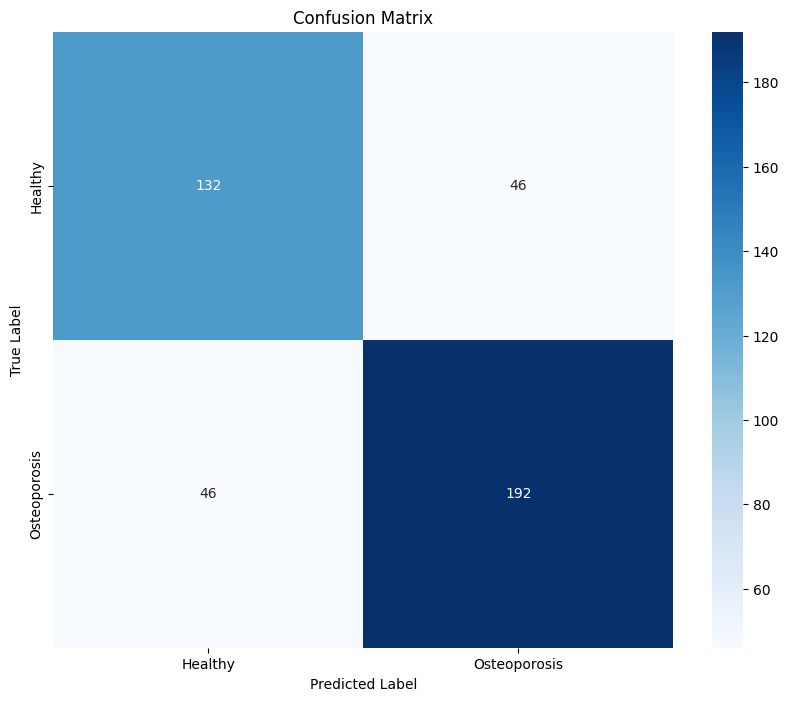

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset the test generator to ensure correct predictions
test.reset()

# Get predictions (probabilities) and true labels
y_pred_prob = alexnet_model.predict(test)
y_pred = np.argmax(y_pred_prob, axis=-1)
y_true = test.classes

# Generate the classification report
class_report = classification_report(y_true, y_pred, target_names=test.class_indices.keys())
print("Classification Report:\n", class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


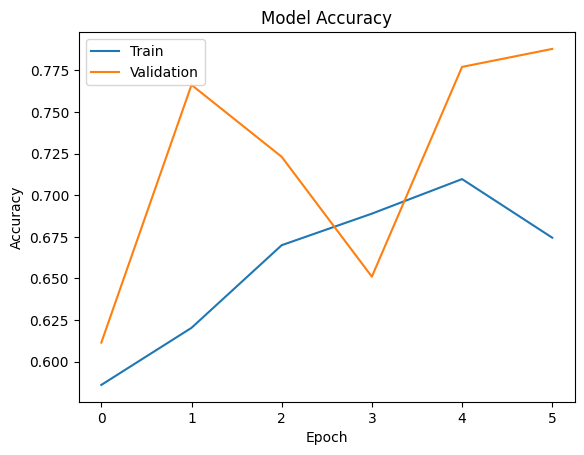

In [19]:
plt.plot(history_alexnet1.history['accuracy'] + history_alexnet2.history['accuracy'])
plt.plot(history_alexnet1.history['val_accuracy'] + history_alexnet2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


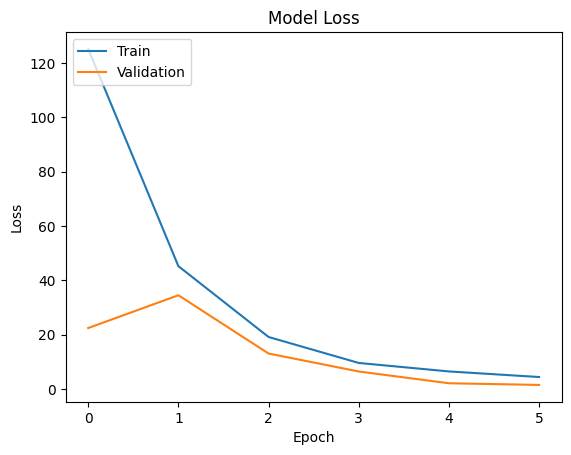

In [20]:
plt.plot(history_alexnet1.history['loss'] + history_alexnet2.history['loss'])
plt.plot(history_alexnet1.history['val_loss'] + history_alexnet2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
